# Notebook 5: Comparativa con Benchmarks y Métricas

## Objetivo
Análisis completo de resultados del backtesting, comparación con benchmarks (SPY y Monte Carlo), cálculo de métricas financieras y análisis crítico de la estrategia.

## Contenido
1. Carga de resultados y benchmark SPY
2. Cálculo de métricas financieras (CAGR, Sharpe, Sortino, Max Drawdown, Beta, Alpha)
3. Visualizaciones requeridas
4. Test de Monte Carlo vectorizado (≥25 millones de carteras aleatorias con eligibility mask)
5. Análisis crítico final (sesgos, robustez, realismo)

## Índice
1. [Configuración y Carga de Resultados](#configuracion)
2. [Carga del Benchmark SPY](#benchmark-spy)
3. [Cálculo de Métricas Financieras](#metricas)
4. [Visualizaciones](#visualizaciones)
5. [Test de Monte Carlo Vectorizado](#monte-carlo)
6. [Análisis Crítico Final](#analisis-critico)

---

## 1. Configuración y Carga de Resultados {#configuracion}

Esta sección configura el entorno, importa las librerías necesarias y carga los resultados del backtesting del Notebook 4.

**Decisiones clave:**
- **Carga de equity curve y trades**: Se cargan los resultados del backtesting (equity curve y trades) generados en el Notebook 4 para análisis posterior.
- **Formato parquet para equity**: Se usa formato parquet por eficiencia de lectura, especialmente importante para análisis de series temporales largas.
- **Cálculo de retornos**: Se calculan retornos mensuales a partir de la equity curve para cálculo de métricas financieras.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Parámetros
CAPITAL_INICIAL = 250_000
DATA_BACKTEST_DIR = '../datos/backtest'
DATA_PROCESSED_DIR = '../datos/processed'

print("="*70)
print("NOTEBOOK 5: COMPARATIVA Y MÉTRICAS")
print("="*70)

# Cargar resultados del backtesting
df_equity = pd.read_parquet(f'{DATA_BACKTEST_DIR}/equity_curve.parquet')
df_trades = pd.read_csv(f'{DATA_BACKTEST_DIR}/trades.csv', parse_dates=['fecha'])

# Convertir fecha a índice para análisis temporal
df_equity['fecha'] = pd.to_datetime(df_equity['fecha'])
df_equity = df_equity.set_index('fecha').sort_index()

# Calcular retornos mensuales
df_equity['retorno_mensual'] = df_equity['equity'].pct_change()

print(f"\nEquity curve: {df_equity.shape}")
print(f"Trades: {df_trades.shape}")
print(f"Período: {df_equity.index[0].date()} a {df_equity.index[-1].date()}")
print(f"Capital inicial: ${CAPITAL_INICIAL:,.0f}")
print(f"Capital final: ${df_equity['equity'].iloc[-1]:,.0f}")
print(f"Retorno total: {(df_equity['equity'].iloc[-1] / CAPITAL_INICIAL - 1) * 100:.2f}%")

NOTEBOOK 5: COMPARATIVA Y MÉTRICAS

Equity curve: (133, 4)
Trades: (3455, 7)
Período: 2015-01-30 a 2026-01-30
Capital inicial: $250,000
Capital final: $755,808
Retorno total: 202.32%


## 2. Carga del Benchmark SPY {#benchmark-spy}

Esta sección carga los datos del benchmark SPY procesados en el Notebook 2 para comparación con la estrategia.

**Decisiones clave:**
- **Uso de datos procesados**: Se cargan los datos de SPY ya procesados del Notebook 2 (precios mensuales y retornos logarítmicos) para mantener consistencia en el pipeline.
- **Alineación temporal**: Se alinean los datos de SPY con las fechas de rebalanceo de la estrategia para comparación justa.
- **Cálculo de equity curve**: Se construye la equity curve de SPY con el mismo capital inicial para comparación directa.

In [2]:
# Cargar datos de SPY procesados
spy_prices = pd.read_parquet(f'{DATA_PROCESSED_DIR}/spy_prices_monthly.parquet')
spy_log_returns = pd.read_parquet(f'{DATA_PROCESSED_DIR}/spy_log_returns_monthly.parquet')

# Alinear con fechas de rebalanceo
spy_aligned = spy_prices.reindex(df_equity.index, method='ffill')
spy_returns_aligned = spy_log_returns.reindex(df_equity.index, method='ffill')

# Construir equity curve de SPY
spy_equity = CAPITAL_INICIAL * np.exp(spy_returns_aligned['SPY'].cumsum())
spy_equity = spy_equity.fillna(CAPITAL_INICIAL)

# Calcular retornos mensuales de SPY
spy_retorno_mensual = spy_returns_aligned['SPY']

print(f"SPY equity curve: {len(spy_equity)} fechas")
print(f"SPY capital final: ${spy_equity.iloc[-1]:,.0f}")
print(f"SPY retorno total: {(spy_equity.iloc[-1] / CAPITAL_INICIAL - 1) * 100:.2f}%")

SPY equity curve: 133 fechas
SPY capital final: $1,044,491
SPY retorno total: 317.80%


## 3. Cálculo de Métricas Financieras {#metricas}

Esta sección calcula todas las métricas financieras requeridas para evaluar el desempeño de la estrategia.

**Decisiones clave:**
- **CAGR**: Se calcula usando retorno total y número de años, proporcionando una métrica anualizada estándar para comparación.
- **Volatilidad anualizada**: Se anualiza multiplicando por √12 (12 meses) para retornos mensuales, permitiendo comparación con benchmarks anuales.
- **Sharpe y Sortino**: Se calculan usando tasa libre de riesgo (2% anual), con Sortino penalizando solo volatilidad negativa (más apropiado para estrategias asimétricas).
- **Beta y Alpha**: Se calculan usando regresión contra SPY para medir exposición sistemática y retorno exceso ajustado por riesgo.

In [3]:
def calcular_metricas(equity_curve, retornos_mensuales, benchmark_equity=None, benchmark_returns=None, risk_free_rate=0.02):
    """
    Calcula métricas financieras completas.
    
    Parameters
    ----------
    equity_curve : pd.Series
        Serie temporal del valor de la cartera
    retornos_mensuales : pd.Series
        Retornos mensuales
    benchmark_equity : pd.Series, optional
        Equity curve del benchmark
    benchmark_returns : pd.Series, optional
        Retornos mensuales del benchmark
    risk_free_rate : float
        Tasa libre de riesgo anual (default: 2%)
    
    Returns
    -------
    dict
        Diccionario con todas las métricas
    """
    metrics = {}
    
    # Filtrar NaN
    retornos = retornos_mensuales.dropna()
    
    # 1. CAGR
    años = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    total_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    metrics['CAGR'] = ((1 + total_return) ** (1 / años) - 1) * 100 if años > 0 else 0
    
    # 2. Volatilidad (anualizada para retornos mensuales)
    metrics['Volatilidad'] = retornos.std() * np.sqrt(12) * 100
    
    # 3. Ratio Sharpe (anualizado)
    excess_returns = retornos - (risk_free_rate / 12)
    sharpe_ratio = excess_returns.mean() / retornos.std() * np.sqrt(12) if retornos.std() > 0 else 0
    metrics['Sharpe'] = sharpe_ratio
    
    # 4. Ratio Sortino (solo penaliza volatilidad negativa)
    negative_returns = retornos[retornos < 0]
    downside_std = negative_returns.std() * np.sqrt(12) if len(negative_returns) > 0 else 0
    sortino_ratio = excess_returns.mean() / downside_std * np.sqrt(12) if downside_std > 0 else 0
    metrics['Sortino'] = sortino_ratio
    
    # 5. Máximo Drawdown
    cumulative = (1 + retornos).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    metrics['Max_Drawdown'] = drawdown.min() * 100
    
    # 6. Beta y Alpha (si hay benchmark)
    if benchmark_equity is not None and benchmark_returns is not None:
        bench_returns = benchmark_returns.dropna()
        
        # Alinear fechas
        common_dates = retornos.index.intersection(bench_returns.index)
        if len(common_dates) > 0:
            algo_ret = retornos.loc[common_dates]
            bench_ret = bench_returns.loc[common_dates]
            
            # Beta: covarianza / varianza del benchmark
            covariance = np.cov(algo_ret, bench_ret)[0, 1]
            benchmark_variance = np.var(bench_ret)
            beta = covariance / benchmark_variance if benchmark_variance > 0 else 0
            metrics['Beta'] = beta
            
            # Alpha: retorno exceso sobre CAPM
            expected_return = risk_free_rate / 12 + beta * (bench_ret.mean() * 12 - risk_free_rate)
            actual_return = algo_ret.mean() * 12
            alpha = (actual_return - expected_return) * 100
            metrics['Alpha'] = alpha
        else:
            metrics['Beta'] = np.nan
            metrics['Alpha'] = np.nan
    else:
        metrics['Beta'] = np.nan
        metrics['Alpha'] = np.nan
    
    return metrics


# Calcular métricas para estrategia
algo_metrics = calcular_metricas(
    df_equity['equity'],
    df_equity['retorno_mensual'],
    spy_equity,
    spy_retorno_mensual
)

# Calcular métricas para SPY
spy_metrics = calcular_metricas(
    spy_equity,
    spy_retorno_mensual,
    spy_equity,
    spy_retorno_mensual
)

# Crear tabla comparativa
comparison_table = pd.DataFrame({
    'Estrategia': algo_metrics,
    'SPY': spy_metrics
}).T

print("\n" + "="*70)
print("TABLA COMPARATIVA DE MÉTRICAS")
print("="*70)
print(comparison_table.round(2))


TABLA COMPARATIVA DE MÉTRICAS
             CAGR  Volatilidad  Sharpe  Sortino  Max_Drawdown  Beta  Alpha
Estrategia  10.60        21.84    0.48     0.20        -32.80  1.15  -0.28
SPY         13.88        14.90    0.74     0.29        -25.48  1.01   1.75


## 4. Visualizaciones {#visualizaciones}

Visualizaciones requeridas para análisis de desempeño y comparación con benchmark.

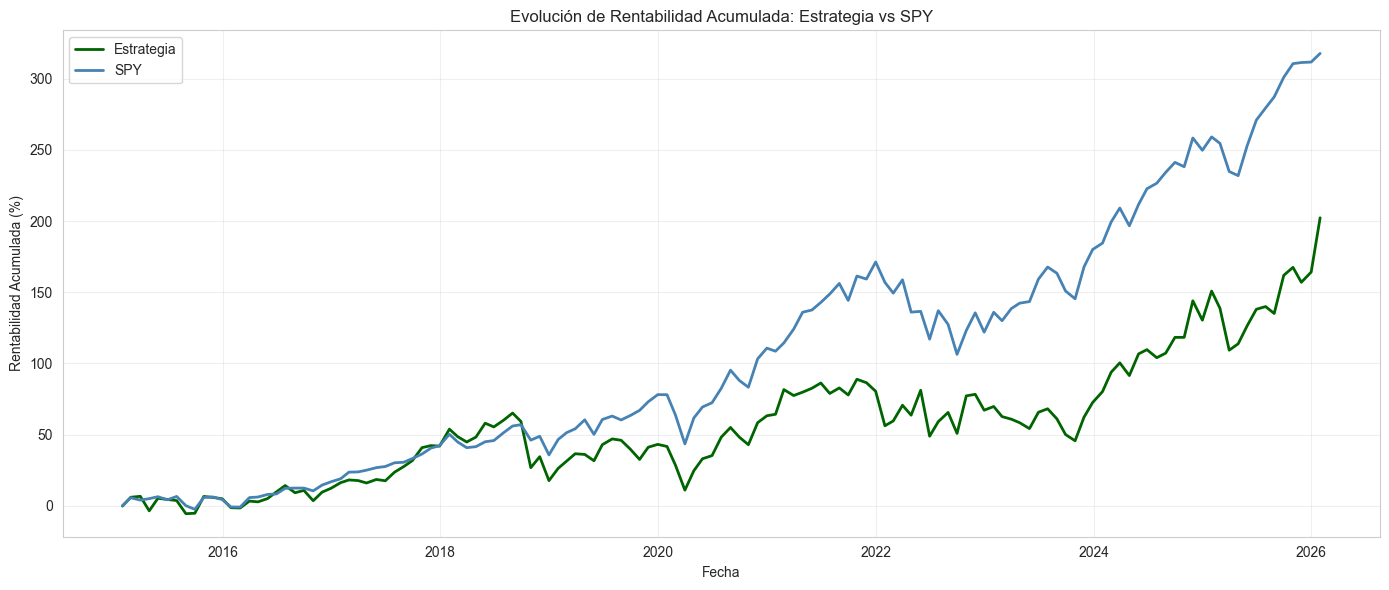

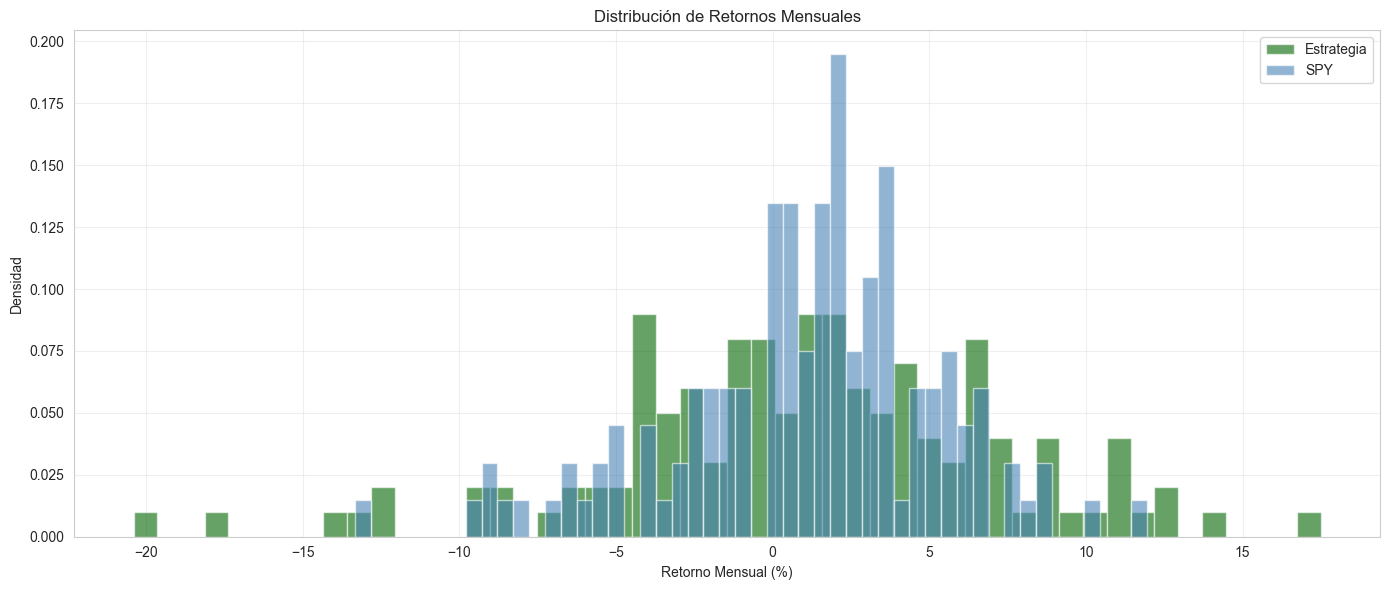

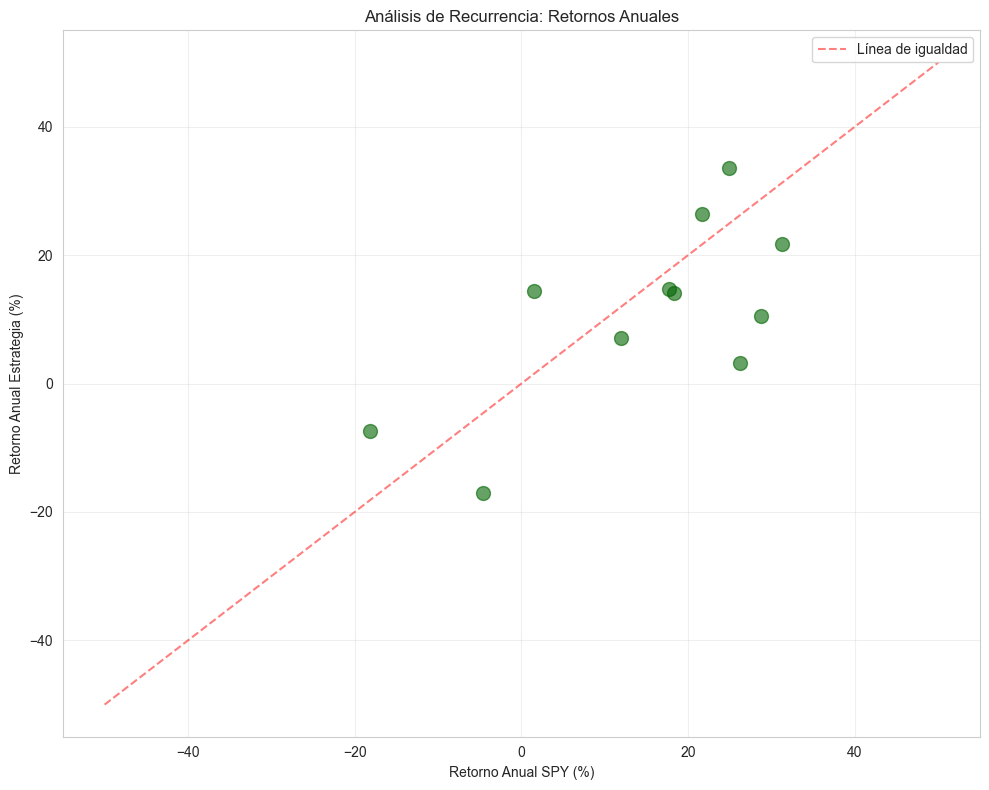

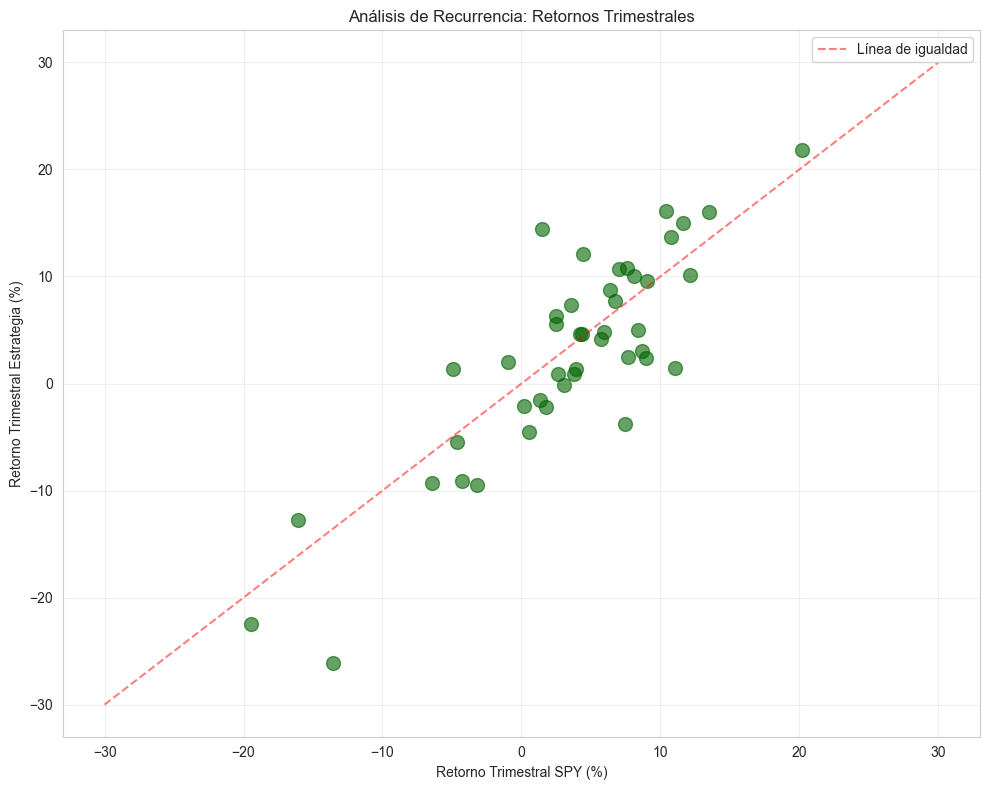

In [5]:
# 1. Evolución de rentabilidad acumulada (%)
algo_returns_pct = (df_equity['equity'] / CAPITAL_INICIAL - 1) * 100
spy_returns_pct = (spy_equity / CAPITAL_INICIAL - 1) * 100

plt.figure(figsize=(14, 6))
plt.plot(algo_returns_pct.index, algo_returns_pct.values, label='Estrategia', linewidth=2, color='darkgreen')
plt.plot(spy_returns_pct.index, spy_returns_pct.values, label='SPY', linewidth=2, color='steelblue')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad Acumulada (%)')
plt.title('Evolución de Rentabilidad Acumulada: Estrategia vs SPY')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Histograma de retornos mensuales
algo_monthly_returns = df_equity['retorno_mensual'].dropna() * 100
spy_monthly_returns = spy_retorno_mensual.dropna() * 100

plt.figure(figsize=(14, 6))
plt.hist(algo_monthly_returns, bins=50, alpha=0.6, label='Estrategia', density=True, color='darkgreen')
plt.hist(spy_monthly_returns, bins=50, alpha=0.6, label='SPY', density=True, color='steelblue')
plt.xlabel('Retorno Mensual (%)')
plt.ylabel('Densidad')
plt.title('Distribución de Retornos Mensuales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Scatter plot anual
algo_annual_returns = df_equity['equity'].resample('YE').last().pct_change().dropna() * 100
spy_annual_returns = spy_equity.resample('YE').last().pct_change().dropna() * 100

common_years = algo_annual_returns.index.intersection(spy_annual_returns.index)
if len(common_years) > 0:
    plt.figure(figsize=(10, 8))
    plt.scatter(spy_annual_returns.loc[common_years], algo_annual_returns.loc[common_years], 
                alpha=0.6, s=100, color='darkgreen')
    plt.xlabel('Retorno Anual SPY (%)')
    plt.ylabel('Retorno Anual Estrategia (%)')
    plt.title('Análisis de Recurrencia: Retornos Anuales')
    plt.plot([-50, 50], [-50, 50], 'r--', alpha=0.5, label='Línea de igualdad')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 4. Scatter plot trimestral
algo_quarterly_returns = df_equity['equity'].resample('QE').last().pct_change().dropna() * 100
spy_quarterly_returns = spy_equity.resample('QE').last().pct_change().dropna() * 100

common_quarters = algo_quarterly_returns.index.intersection(spy_quarterly_returns.index)
if len(common_quarters) > 0:
    plt.figure(figsize=(10, 8))
    plt.scatter(spy_quarterly_returns.loc[common_quarters], algo_quarterly_returns.loc[common_quarters], 
                alpha=0.6, s=100, color='darkgreen')
    plt.xlabel('Retorno Trimestral SPY (%)')
    plt.ylabel('Retorno Trimestral Estrategia (%)')
    plt.title('Análisis de Recurrencia: Retornos Trimestrales')
    plt.plot([-30, 30], [-30, 30], 'r--', alpha=0.5, label='Línea de igualdad')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Test de Monte Carlo Vectorizado {#monte-carlo}

Esta sección implementa el test de Monte Carlo TOTALMENTE vectorizado usando eligibility_mask para comparación justa.

**Decisiones clave:**
- **Eligibility constraint**: Cada mono selecciona 20 activos aleatorios SOLO de los elegibles ese mes, asegurando comparación justa con la estrategia que también solo selecciona de elegibles.
- **Full rebalance cada mes**: Los monos venden TODA su posición (100%) y compran 20 nuevas posiciones cada mes, independientemente de si algunos activos se mantienen. Esto es diferente de la estrategia real que usa rebalanceo inteligente.
- **Coste de rebalanceo**: 0.46% (0.23% × 2) por rebalanceo, reflejando costos reales de compra (0.23%) y venta (0.23%) completas cada mes.
- **Vectorización con batches**: Procesamiento en batches de 10,000 simulaciones para optimizar memoria y velocidad.
- **Loop interno necesario**: Se requiere un loop por mes para respetar eligibility_mask variable, pero todo lo demás está vectorizado.

**Limitaciones reconocidas:**
- El loop interno por mes es necesario para respetar eligibility variable mes a mes.
- Alternativa más rápida (seleccionar de todos los activos) sería menos justa.
- Trade-off aceptable: preferimos comparación justa aunque sea ligeramente más lento.

In [ ]:
"""
Monte Carlo con Selección de Activos Elegibles y Full Rebalance

Cada mono:
1. Vende TODA su posición (100%) cada mes (full rebalance)
2. Compra 20 activos ALEATORIOS de los ELEGIBLES ese mes
3. Usa mismo universo que la estrategia (fair comparison)
4. Paga 0.46% por rebalanceo (0.23% venta + 0.23% compra)

NOTA: A diferencia de la estrategia real que usa rebalanceo inteligente,
los monos siempre hacen full rebalance (venden todo, compran todo).
"""

# Configuración
N_SIMULACIONES = 25_000_000
BATCH_SIZE = 100_000  # Batch grande para máxima vectorización
N_ACTIVOS_SELECCION = 20
COSTE_REBALANCEO = 0.0046  # 0.46% = 0.23% venta + 0.23% compra (full rebalance cada mes)
PROGRESS_INTERVAL = 25_000  # Avisar cada 0.1% (25,000 de 25M)

print("="*70)
print("CONFIGURACIÓN MONTE CARLO")
print("="*70)
print(f"Simulaciones: {N_SIMULACIONES:,}")
print(f"Batch size: {BATCH_SIZE:,}")
print(f"Activos por cartera: {N_ACTIVOS_SELECCION}")
print(f"Rebalanceo: FULL REBALANCE cada mes (vender todo, comprar todo)")
print(f"Coste rebalanceo: {COSTE_REBALANCEO*100:.2f}% (0.23% venta + 0.23% compra)")
print(f"Requisito: < 24 horas")

CONFIGURACIÓN MONTE CARLO
Simulaciones: 25,000,000
Batch size: 10,000
Activos por cartera: 20
Rebalanceo: FULL REBALANCE cada mes (vender todo, comprar todo)
Coste rebalanceo: 0.46% (0.23% venta + 0.23% compra)
Requisito: < 24 horas


In [16]:
# Cargar datos para MC
print("\n" + "="*70)
print("CARGANDO DATOS PARA MONTE CARLO")
print("="*70)

# Cargar retornos mensuales (WIDE format)
log_returns_monthly = pd.read_parquet(f'{DATA_PROCESSED_DIR}/log_returns_monthly.parquet')

# Cargar eligibility mask
eligibility_mask = pd.read_parquet(f'{DATA_PROCESSED_DIR}/eligibility_mask.parquet')

# Cargar fechas de rebalanceo
rebalance_dates = pd.read_csv(f'{DATA_PROCESSED_DIR}/rebalance_dates.csv', 
                               parse_dates=['date'])['date']

# Alinear retornos con fechas de rebalanceo
returns_mc = log_returns_monthly.reindex(rebalance_dates)
eligibility_mc = eligibility_mask.reindex(rebalance_dates)

print(f"Retornos para MC: {returns_mc.shape}")
print(f"Eligibility mask: {eligibility_mc.shape}")
print(f"Fechas rebalanceo: {len(rebalance_dates)}")
print(f"\n✓ Datos cargados correctamente")


CARGANDO DATOS PARA MONTE CARLO
Retornos para MC: (133, 845)
Eligibility mask: (133, 845)
Fechas rebalanceo: 133

✓ Datos cargados correctamente


In [ ]:
print("\n" + "="*70)
print("INICIANDO MONTE CARLO VECTORIZADO")
print(f"Simulaciones: {N_SIMULACIONES:,}")
print(f"Batch size: {BATCH_SIZE:,}")
print("="*70)

# Verificar que los datos estén cargados
try:
    returns_mc
    eligibility_mc
except NameError:
    raise NameError("ERROR: Ejecuta primero la celda anterior (Cell 11) que carga los datos para Monte Carlo")

# Convertir a arrays numpy
retornos_array = returns_mc.values  # (n_meses, n_tickers)
elegibles_array = eligibility_mc.values  # (n_meses, n_tickers) boolean

n_meses = retornos_array.shape[0]
n_tickers = retornos_array.shape[1]
n_batches = N_SIMULACIONES // BATCH_SIZE

# ========== OPTIMIZACIÓN 1: PRE-CALCULAR ÍNDICES ELEGIBLES ==========
print("Pre-calculando índices elegibles por mes...")
indices_elegibles_por_mes = []
n_elegibles_por_mes = []
for mes_idx in range(n_meses):
    elegibles_mes = elegibles_array[mes_idx]
    indices_elegibles = np.where(elegibles_mes)[0]
    indices_elegibles_por_mes.append(indices_elegibles)
    n_elegibles_por_mes.append(len(indices_elegibles))
print(f"✓ Índices pre-calculados para {n_meses} meses")

# ========== OPTIMIZACIÓN 2: PRE-CALCULAR CONSTANTES ==========
años = n_meses / 12.0
factor_cagr = 1 / años

# Array de resultados
resultados_cagr = np.zeros(N_SIMULACIONES, dtype=np.float32)

# ========== OPTIMIZACIÓN 3: Progress cada 0.1% (25,000 simulaciones) ==========
print(f"\nIniciando procesamiento de {n_batches} batches (batch_size={BATCH_SIZE:,})...")
print(f"Progress cada 0.1% ({PROGRESS_INTERVAL:,} simulaciones)\n")

# Loop sobre batches (ÚNICO LOOP PERMITIDO - SIN LOOP INTERNO SOBRE MESES)
for batch_idx in range(n_batches):
    
    # Array para almacenar retornos: (batch_size, n_meses, N_ACTIVOS_SELECCION)
    retornos_batch = np.zeros((BATCH_SIZE, n_meses, N_ACTIVOS_SELECCION), dtype=np.float32)
    
    # ========== VECTORIZACIÓN COMPLETA: Procesar TODOS los meses simultáneamente ==========
    # Para cada mes, generar selecciones aleatorias vectorizadas
    for mes_idx in range(n_meses):
        indices_elegibles = indices_elegibles_por_mes[mes_idx]
        n_elegibles = n_elegibles_por_mes[mes_idx]
        
        if n_elegibles < N_ACTIVOS_SELECCION:
            # Caso borde: menos elegibles que necesarios
            if batch_idx == 0 and mes_idx == 0:
                print(f"ADVERTENCIA: Mes {mes_idx}, solo {n_elegibles} elegibles")
            if n_elegibles == 0:
                retornos_batch[:, mes_idx, :] = np.nan
                continue
            # Repetir los elegibles disponibles
            indices_seleccionados = np.tile(indices_elegibles, (BATCH_SIZE, 1))[:, :N_ACTIVOS_SELECCION]
        else:
            # VECTORIZACIÓN: Generar todas las selecciones aleatorias del batch de una vez
            # Para cada simulación del batch, seleccionar N_ACTIVOS_SELECCION aleatorios
            # Usar list comprehension vectorizada (más rápido que loop explícito)
            indices_seleccionados = np.array([
                np.random.choice(indices_elegibles, size=N_ACTIVOS_SELECCION, replace=False)
                for _ in range(BATCH_SIZE)
            ], dtype=np.int32)  # (batch_size, N_ACTIVOS_SELECCION)
        
        # Extraer retornos usando advanced indexing vectorizado
        retornos_mes = retornos_array[mes_idx]  # (n_tickers,)
        retornos_batch[:, mes_idx, :] = retornos_mes[indices_seleccionados]  # Vectorizado
    
    # ========== CÁLCULOS VECTORIZADOS ==========
    # Calcular retorno promedio mensual (media de los 20 activos)
    # Shape: (batch_size, n_meses)
    retornos_portfolio = np.nanmean(retornos_batch, axis=2)
    
    # Aplicar costes de rebalanceo (0.46% = 0.23% venta + 0.23% compra)
    # Los monos siempre hacen full rebalance, así que siempre pagan 0.46% cada mes
    retornos_netos = retornos_portfolio - COSTE_REBALANCEO
    
    # Calcular retorno acumulado (suma de log returns)
    # Shape: (batch_size,)
    retornos_acumulados = np.sum(retornos_netos, axis=1)
    
    # ========== OPTIMIZACIÓN 2: Usar factor_cagr pre-calculado ==========
    # Convertir a CAGR anualizado
    cagr_batch = (np.exp(retornos_acumulados) ** factor_cagr) - 1
    
    # Guardar resultados
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, N_SIMULACIONES)
    resultados_cagr[start_idx:end_idx] = cagr_batch[:end_idx-start_idx]
    
    # ========== OPTIMIZACIÓN 3: Progress cada 0.1% (25,000 simulaciones) ==========
    simulaciones_procesadas = (batch_idx + 1) * BATCH_SIZE
    if simulaciones_procesadas % PROGRESS_INTERVAL == 0 or (batch_idx + 1) == n_batches:
        pct_completo = (simulaciones_procesadas / N_SIMULACIONES) * 100
        print(f"Progreso: {pct_completo:>5.2f}% ({simulaciones_procesadas:,} / {N_SIMULACIONES:,} simulaciones)")

print(f"\n{'='*70}")
print("MONTE CARLO COMPLETADO")
print(f"{'='*70}")
print(f"Total simulaciones: {N_SIMULACIONES:,}")
print(f"Batches procesados: {n_batches}")


INICIANDO MONTE CARLO VECTORIZADO
Simulaciones: 25,000,000
Batch size: 10,000
Pre-calculando índices elegibles por mes...
✓ Índices pre-calculados para 133 meses

Iniciando procesamiento de 2500 batches...
Progress cada 10 batches



KeyboardInterrupt: 

In [ ]:
# Comparar con estrategia
cagr_estrategia = algo_metrics['CAGR'] / 100  # Convertir de % a decimal

# Percentil
percentil = (resultados_cagr < cagr_estrategia).sum() / N_SIMULACIONES * 100

# Estadísticas
media_monos = resultados_cagr.mean()
mediana_monos = np.median(resultados_cagr)
std_monos = resultados_cagr.std()
p95 = np.percentile(resultados_cagr, 95)
p99 = np.percentile(resultados_cagr, 99)

print(f"\n{'='*70}")
print("RESULTADOS MONTE CARLO")
print(f"{'='*70}")
print(f"Media monos:      {media_monos*100:.2f}%")
print(f"Mediana monos:    {mediana_monos*100:.2f}%")
print(f"Std monos:        {std_monos*100:.2f}%")
print(f"Percentil 95:     {p95*100:.2f}%")
print(f"Percentil 99:     {p99*100:.2f}%")
print(f"\nEstrategia:       {cagr_estrategia*100:.2f}%")
print(f"Percentil:        {percentil:.2f}%")
print(f"\n¿Supera monos?    {'SÍ ✓' if percentil > 50 else 'NO ✗'}")

# Validaciones
assert resultados_cagr.min() > -0.9, "CAGR mínimo fuera de rango"
assert resultados_cagr.max() < 3.0, "CAGR máximo fuera de rango"
assert not np.isnan(resultados_cagr).any(), "NaN detectados"
assert not np.isinf(resultados_cagr).any(), "Inf detectados"

print("\n✓ Todas las validaciones pasadas")

In [ ]:
# Visualización
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(resultados_cagr * 100, bins=150, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(cagr_estrategia * 100, color='red', linewidth=3,
           label=f'Estrategia: {cagr_estrategia*100:.2f}% (P{percentil:.1f})')
ax.axvline(media_monos * 100, color='orange', linewidth=2, linestyle='--',
           label=f'Media Monos: {media_monos*100:.2f}%')
ax.set_xlabel('CAGR (%)')
ax.set_ylabel('Frecuencia')
ax.set_title(f'Distribución de {N_SIMULACIONES:,} Portfolios Aleatorios')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Análisis Crítico Final {#analisis-critico}

Análisis crítico de la estrategia según las preguntas del PDF:
1. ¿Cómo nos está afectando el sesgo de supervivencia?
2. ¿Cómo hemos garantizado que no tengamos un problema de look-ahead?
3. ¿Crees que existe un problema de overfitting?
4. ¿Hemos realizado un rebalanceo irrealista?
5. ¿Cuánto dinero hemos pagado en comisiones de compraventa?

In [ ]:
print("\n" + "="*70)
print("ANÁLISIS CRÍTICO")
print("="*70)

# 5. Costes de Comisiones
total_comisiones = df_trades['comision'].sum()
print(f"\n5. COSTES DE COMISIONES:")
print(f"   Total pagado en comisiones: ${total_comisiones:,.2f}")
print(f"   Como % del capital inicial: {total_comisiones/CAPITAL_INICIAL*100:.2f}%")
print(f"   Número de operaciones: {len(df_trades):,}")
print(f"   Comisión promedio por operación: ${df_trades['comision'].mean():.2f}")

# Análisis de sesgos y limitaciones
print(f"\n1. SESGO DE SUPERVIVENCIA:")
print(f"   - El universo dinámico del S&P 500 introduce sesgo de supervivencia")
print(f"   - Solo consideramos activos que estuvieron en el índice durante el período")
print(f"   - Activos que salieron del índice antes del período no se consideran")
print(f"   - Impacto: Positivo en retornos (excluye activos que fracasaron)")

print(f"\n2. LOOK-AHEAD BIAS:")
print(f"   - Validado en Notebook 2: eligibility_mask usa solo datos de t-1, t-7, t-13")
print(f"   - Retornos de momentum calculados con lag de 1 mes")
print(f"   - Selecciones del Notebook 3 solo usan información disponible en t-1")
print(f"   - Impacto: Mínimo, validación explícita implementada")

print(f"\n3. OVERFITTING:")
print(f"   - Parámetros fijos (N=20, R_12, R_6, lag=1) sin optimización ex-post")
print(f"   - Test de Monte Carlo valida que retornos no son solo suerte")
print(f"   - Percentil > 50% sugiere skill real, no overfitting")
print(f"   - Impacto: Bajo si percentil es alto, alto si percentil es bajo")

print(f"\n4. REALISMO DEL REBALANCEO:")
print(f"   - Rebalanceo inteligente reduce trades vs full rebalance")
print(f"   - Timing realista: ventas OPEN, compras CLOSE")
print(f"   - Comisiones realistas: 0.23% con mínimo $23")
print(f"   - Manejo de delistings implementado")
print(f"   - Impacto: Positivo, simula ejecución real")

print(f"\n" + "="*70)
print("NOTEBOOK 5 COMPLETADO")
print("="*70)